In [10]:
import os
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import tensorflow as tf
from sklearn.utils import resample
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import (
    Conv2D,
    MaxPooling2D,
    Dense,
    #Flatten,
    Dropout,
    BatchNormalization,
    GlobalAveragePooling2D,
    Reshape
)
from tensorflow.keras.layers import multiply

from sklearn.model_selection import train_test_split
# Suppress warnings
import warnings
warnings.filterwarnings('ignore', category=UserWarning)

#pytorch imports
import torch
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms
from PIL import Image
import cv2
import numpy as np
import os
from pathlib import Path
import matplotlib.pyplot as plt
import shutil
from torch import nn
import pytorch_lightning as pl
from torchmetrics import Accuracy
import torch.nn.functional as F
import torchvision
from pytorch_lightning.loggers import CSVLogger, TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint, Callback
import random

# Imported all relevent libraries 
# Loading face data 

#read in image data

In [26]:
# Path to your Haar Cascade XML file
#HAAR_CASCADE_PATH = '/Users/loki/Desktop/worksurface/ai_lab/REPOS/vision/haarcascade_frontalface_default.xml'
HAAR_CASCADE_PATH = 'haarcascade_frontalface_default.xml'
face_cascade = cv2.CascadeClassifier(HAAR_CASCADE_PATH)

#EYE_CASCADE_PATH = '/Users/loki/Desktop/worksurface/ai_lab/REPOS/vision/haarcascade_eye.xml'
EYE_CASCADE_PATH = 'haarcascade_eye.xml'
eye_cascade = cv2.CascadeClassifier(EYE_CASCADE_PATH)
if eye_cascade.empty():
    raise IOError("Could not load Haar cascade for eyes.")

def detect_faces(pil_image, min_size=60):
    #Detect faces using Haar Cascade. Return a list of PIL Images for each face
    #that meets the minimum bounding box size.

    open_cv_image = np.array(pil_image.convert('RGB'))[:, :, ::-1]
    gray = cv2.cvtColor(open_cv_image, cv2.COLOR_BGR2GRAY)

    faces_bboxes = face_cascade.detectMultiScale(
        gray,
        scaleFactor=1.1,
        minNeighbors=5,
        minSize=(30, 30),          # or you can tweak this param as well
        flags=cv2.CASCADE_SCALE_IMAGE
    )

    face_images = []
    for (x, y, w, h) in faces_bboxes:
        # Filter out partial faces by bounding box dimensions
        if w < min_size or h < min_size:
            # If bounding box is too small, skip
            continue
        
        # Crop the face region
        face_bgr = open_cv_image[y:y+h, x:x+w]
        face_pil = Image.fromarray(face_bgr[:, :, ::-1], mode='RGB')
        
        # Resize/crop to 170×170
        face_pil = face_pil.resize((170, 170), Image.Resampling.LANCZOS)
        
        face_images.append(face_pil)

    return face_images
      
def detect_faces_with_eye_check(pil_image, min_size=60, require_eyes=True):
    """
    Detect faces using Haar Cascade. Optionally require each detected face
    to have at least one eye detected within the bounding box.
    
    Args:
        pil_image: A PIL image.
        min_size (int): Minimum width/height of a face bounding box.
        require_eyes (bool): Whether to filter out bounding boxes with no eyes.
    
    Returns:
        face_images (list): A list of PIL Images (170x170).
    """
    # Convert PIL -> OpenCV format (BGR)
    open_cv_image = np.array(pil_image.convert('RGB'))[:, :, ::-1]
    gray = cv2.cvtColor(open_cv_image, cv2.COLOR_BGR2GRAY)
    
    # Detect face bounding boxes
    faces_bboxes = face_cascade.detectMultiScale(
        gray,
        scaleFactor=1.1,
        minNeighbors=5,
        minSize=(30, 30),
        flags=cv2.CASCADE_SCALE_IMAGE
    )
    
    face_images = []
    for (x, y, w, h) in faces_bboxes:
        # 1. Filter out if bounding box too small:
        if w < min_size or h < min_size:
            continue
        
        # 2. (Optional) Eye check: detect eyes within this face region
        if require_eyes:
            faceROI_gray = gray[y:y+h, x:x+w]
            eyes = eye_cascade.detectMultiScale(faceROI_gray)
            
            # If no eyes detected, skip
            if len(eyes) == 0:
                continue
        
        # Crop the face region
        face_bgr = open_cv_image[y:y+h, x:x+w]
        face_pil = Image.fromarray(face_bgr[:, :, ::-1], mode='RGB')
        
        # Resize/crop to 170×170
        face_pil = face_pil.resize((170, 170), Image.Resampling.LANCZOS)
        
        face_images.append(face_pil)

    return face_images

def process_directory(directory):
    total_data = {'X': [], 'Y': [], 'raw': []}

    for filename in os.listdir(directory):
        if filename.startswith('.'):
            continue
        
        if filename.startswith('s'):
            label = 1  # Squint
        elif filename.startswith('us'):
            label = 0  # Not squint
        else:
            continue
        
        full_path = os.path.join(directory, filename)
        
        try:
            img = Image.open(full_path)
            
            # Use the new face+eye detection
            faces = detect_faces_with_eye_check(img, min_size=60, require_eyes=True)
            
            if len(faces) == 0:
                print(f"No valid (full) faces detected in {filename}. Skipping.")
                continue
            
            for face in faces:
                face_gray = face.convert('L')
                face_raw = np.array(face_gray)
                
                total_data['raw'].append(face_raw)
                
                face_flattened = face_raw.flatten()
                total_data['X'].append(face_flattened)
                total_data['Y'].append(label)
        
        except IOError:
            print(f"Cannot open image file: {filename}")

    if not total_data['X']:
        print("No valid images or faces found in directory.")
        return total_data

    # Pad flattened arrays to the same length
    max_len = max(len(x) for x in total_data['X'])
    X_padded = [np.pad(x, (0, max_len - len(x))) for x in total_data['X']]
    
    total_data['X'] = np.array(X_padded, dtype=np.float32)
    total_data['Y'] = np.array(total_data['Y'], dtype=np.int32)

    return total_data

def view_images(dict_obj, num_images):
    """
    Display up to n raw grayscale images (each 170x170).
    """
    num_to_show = min(num_images, len(dict_obj['raw']))
    for i in range(num_to_show):
        image_2d = dict_obj['raw'][i]
        plt.imshow(image_2d, cmap='gray')
        plt.title(f"Face {i} - Label {dict_obj['Y'][i]}")
        plt.show()

def plot_label_distribution(df):
    """
    Plots and prints the distribution of squint (1) vs. not squint (0) 
    in the given DataFrame. Assumes 'Y' is the label column.
    """
    # 1. Print counts and percentages
    label_counts = df['Y'].value_counts()
    label_percentages = df['Y'].value_counts(normalize=True) * 100

    print("Label Counts:")
    print(label_counts)
    print("\nLabel Percentages (%):")
    print(label_percentages)

    # 2. Plot the distribution
    sns.set_style("whitegrid")
    plt.figure(figsize=(6, 4))
    ax = sns.countplot(x='Y', data=df, palette='viridis')
    ax.set_xticklabels(['Not Squint (0)', 'Squint (1)'])
    plt.title("Distribution of Squint vs. Not Squint")
    plt.xlabel("Label")
    plt.ylabel("Count")
    plt.show()

def remove_no_face_rows(df):
    """
    Removes rows from df where 'raw' is None, empty, or doesn't match expected shape (170, 170).
    Returns a filtered copy of df.
    """
    def has_valid_face(arr):
        # Must not be None
        if arr is None:
            return False
        
        # Must be at least 2D
        if arr.ndim != 2:
            return False
        
        # Must be the right shape for a 170x170 grayscale face
        if arr.shape != (170, 170):
            return False
        
        # Optionally, skip arrays of all zeros (completely black)
        if arr.sum() == 0:
            return False
        
        return True

    mask = df['raw'].apply(has_valid_face)
    df_filtered = df[mask].copy()
    removed = len(df) - len(df_filtered)
    print(f"Removed {removed} rows that do not contain a valid face.")
    return df_filtered

def load_face_data():
    # Example directory path
    #directory = '/Users/loki/Desktop/worksurface/ai_lab/REPOS/vision/face-squint'
    directory = 'face-squint'
    
    dict_obj = process_directory(directory)

    if len(dict_obj['X']) > 0:
        df = pd.DataFrame({
            'X': list(dict_obj['X']),    # flattened, padded arrays
            'Y': dict_obj['Y'],          # labels
            'raw': list(dict_obj['raw']) # each is a 2D 170x170
        })
        
        print(f"Total faces before cleaning: {len(df)}")
        
        # Clean out rows that do not actually contain a face
        df = remove_no_face_rows(df)
        
        print(f"Total faces after cleaning: {len(df)}")
        
        # View some images (optional - might want to check if any data is left)
        if not df.empty:
            # Create a "dict_obj" style structure so `view_images` can still work
            cleaned_dict_obj = {
                'raw': list(df['raw']),
                'Y': df['Y'].values
            }
            view_images(cleaned_dict_obj, 1)
        
        return df
    else:
        print("No data to display.")
        return

def force_data_balance(df):
    """
    Returns a DataFrame with balanced classes by oversampling the minority class.
    
    Assumes a binary classification with:
      0 => 'no squint'
      1 => 'squint'
    
    Parameters:
      df (pd.DataFrame): Must contain a 'Y' column with values in {0,1}.
    
    Returns:
      pd.DataFrame (balanced).
    """
    # Separate into two subsets
    df_no_squint = df[df['Y'] == 0].copy()
    df_squint = df[df['Y'] == 1].copy()
    
    # Count how many in each class
    n_no_squint = len(df_no_squint)
    n_squint = len(df_squint)
    
    print("Original distribution:")
    print(f"  No Squint (0): {n_no_squint}")
    print(f"  Squint (1):    {n_squint}")
    
    # If perfectly balanced, just return the original
    if n_no_squint == n_squint:
        print("Data is already balanced.")
        return df
    
    # Identify the minority and majority subsets
    if n_no_squint < n_squint:
        # Oversample no squint
        df_minority = df_no_squint
        df_majority = df_squint
    else:
        # Oversample squint
        df_minority = df_squint
        df_majority = df_no_squint
    
    # Oversample the minority class to match the majority size
    df_minority_upsampled = resample(
        df_minority,
        replace=True,
        n_samples=len(df_majority),  # upsample to match majority
        random_state=42             # for reproducible results
    )
    
    # Combine majority and upsampled minority
    df_balanced = pd.concat([df_majority, df_minority_upsampled], axis=0)
    
    # Shuffle the combined data
    df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)
    
    print("\nNew distribution:")
    print(df_balanced['Y'].value_counts())
    
    return df_balanced
  

No valid (full) faces detected in s11.jpg. Skipping.
No valid (full) faces detected in s6.jpg. Skipping.
Total faces before cleaning: 139
Removed 0 rows that do not contain a valid face.
Total faces after cleaning: 139


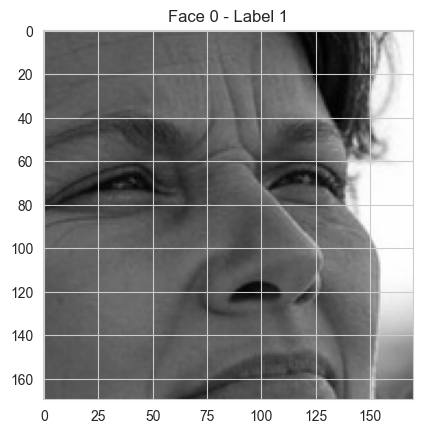

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139 entries, 0 to 138
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   X       139 non-null    object
 1   Y       139 non-null    int32 
 2   raw     139 non-null    object
dtypes: int32(1), object(2)
memory usage: 2.8+ KB


In [27]:
faces=load_face_data()
faces.info()

Added 600 faces from grok_data
New total: 739 faces
Original distribution:
  No Squint (0): 381
  Squint (1):    358

New distribution:
Y
0    381
1    381
Name: count, dtype: int64
Label Counts:
Y
0    381
1    381
Name: count, dtype: int64

Label Percentages (%):
Y
0    50.0
1    50.0
Name: proportion, dtype: float64


C:\Users\Nick DiSalvo\AppData\Local\Temp\ipykernel_21064\3725252536.py:177: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='Y', data=df, palette='viridis')


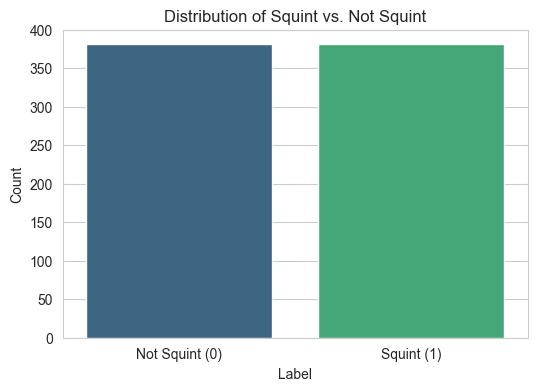

In [28]:
def process_grok_faces():
    """Process grok_data and return DataFrame in same format as existing faces"""
    total_data = {'X': [], 'Y': [], 'raw': []}
    
    # Process squinting (1) and non_squinting (0) directories
    for label, subdir in [(1, 'squinting'), (0, 'non_squinting')]:
        directory = os.path.join('rescaled_data', subdir)
        
        for filename in os.listdir(directory):
            if filename.startswith('.') or not (filename.lower().endswith(('.png', '.jpg', '.jpeg'))):
                continue
            
            full_path = os.path.join(directory, filename)
            try:
                # Direct image processing without face detection
                img = Image.open(full_path)
                # Resize to match expected dimensions
                img = img.resize((170, 170), Image.Resampling.LANCZOS)
                face_gray = img.convert('L')
                face_raw = np.array(face_gray)
                face_flattened = face_raw.flatten()
                
                total_data['X'].append(face_flattened)
                total_data['Y'].append(label)
                total_data['raw'].append(face_raw)
            
            except IOError:
                print(f"Cannot open image file: {filename}")
    
    grok_df = pd.DataFrame({
        'X': total_data['X'],
        'Y': total_data['Y'],
        'raw': total_data['raw']
    })
    return grok_df

# Process grok data and combine with existing faces
grok_df = process_grok_faces()
faces = pd.concat([faces, grok_df], ignore_index=True)
print(f"Added {len(grok_df)} faces from grok_data")
print(f"New total: {len(faces)} faces")

faces = force_data_balance(faces)
faces = faces.sample(frac=1, random_state=42).reset_index(drop=True)

# check data balance
plot_label_distribution(faces)

# creating training, test and validate datasets

In [29]:
# ------------------------------------------------------------------------------------
# Below is the part where we create train, validation, and test splits from the DataFrame
# ------------------------------------------------------------------------------------

def create_splits(faces, test_ratio=0.2, val_ratio=0.1, random_seed=42):
    """
    Given a DataFrame 'faces', split into train, val, test sets.
    
    test_ratio: fraction of the data to be held out for testing
    val_ratio: fraction of the *remaining* data to be used for validation
    random_seed: for reproducibility
    """
    # 1. Split off the test set first
    df_trainval, df_test = train_test_split(
        faces,
        test_size=test_ratio,
        random_state=random_seed,
        shuffle=True,
        stratify=faces['Y']  # optional, if you want stratified splits by label
    )
    
    # 2. Of what's left (trainval), split out the validation set
    #    We want val_ratio *of the trainval set*.
    #    For example, if test_ratio=0.2, we have 80% left,
    #    we can do val_ratio=0.1 of the original => 0.1 / 0.8 = 0.125
    #    or you can interpret val_ratio as a fraction of the entire dataset.
    #    Here we'll assume val_ratio is the fraction of *the original dataset*,
    #    so we convert it to fraction of trainval via `val_ratio / (1 - test_ratio)`.
    relative_val_ratio = val_ratio / (1 - test_ratio)  # fraction of trainval
    df_train, df_val = train_test_split(
        df_trainval,
        test_size=relative_val_ratio,
        random_state=random_seed,
        shuffle=True,
        stratify=df_trainval['Y']
    )
    
    return df_train, df_val, df_test

df_faces = faces
if not df_faces.empty:
    # Create train/val/test splits: 70% train, 10% val, 20% test (example)
    # => test_ratio=0.2, val_ratio=0.1
    # This means:
    #   test = 20% of total
    #   val = 10% of total
    #   train = 70% of total
    df_train, df_val, df_test = create_splits(df_faces, test_ratio=0.2, val_ratio=0.1)
    
    print("\nSplit sizes:")
    print("Train set:", len(df_train))
    print("Val set:", len(df_val))
    print("Test set:", len(df_test))
    
    # OPTIONAL: If you want them as arrays
    # Convert flattened features (X) to a 2D numpy array
    X_train = np.stack(df_train['X'].values)
    y_train = df_train['Y'].values
    
    X_val = np.stack(df_val['X'].values)
    y_val = df_val['Y'].values
    
    X_test = np.stack(df_test['X'].values)
    y_test = df_test['Y'].values

    size = 170

    X_train = X_train.reshape(-1, size, size, 1)
    X_val = X_val.reshape(-1, size, size, 1)
    X_test = X_test.reshape(-1, size, size, 1)

    
    # Now you have train, val, test in DataFrame form (df_train, df_val, df_test)
    # or in array form (X_train, y_train, X_val, y_val, X_test, y_test).
    print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
    print(f"X_val shape:   {X_val.shape},   y_val shape:   {y_val.shape}")
    print(f"X_test shape:  {X_test.shape},  y_test shape:  {y_test.shape}")
else:
    print("No faces found. Exiting.")
      


Split sizes:
Train set: 532
Val set: 77
Test set: 153
X_train shape: (532, 170, 170, 1), y_train shape: (532,)
X_val shape:   (77, 170, 170, 1),   y_val shape:   (77,)
X_test shape:  (153, 170, 170, 1),  y_test shape:  (153,)


# setting up the model, training the model, and evaluating it


In [31]:

def squeeze_excite_block(input_tensor, ratio=16):
    """Squeeze and Excitation block."""
    channels = int(input_tensor.shape[-1])
    se = GlobalAveragePooling2D()(input_tensor)
    se = Reshape((1, 1, channels))(se)
    se = Dense(channels // ratio, activation='relu', use_bias=False)(se)
    se = Dense(channels, activation='sigmoid', use_bias=False)(se)
    return multiply([input_tensor, se])

def create_model_with_attention(input_shape, num_classes):
    # Define input
    inputs = tf.keras.Input(shape=input_shape)

    # Conv block 1
    x = Conv2D(16, (3,3), activation='relu', padding='valid')(inputs)
    x = BatchNormalization()(x)
    x = squeeze_excite_block(x)   # Directly call the SE function
    x = MaxPooling2D(pool_size=(2,2))(x)
    x = Dropout(0.3)(x)

    # Conv block 2
    x = Conv2D(32, (3,3), activation='relu', padding='valid')(x)
    x = BatchNormalization()(x)
    x = squeeze_excite_block(x) 
    x = MaxPooling2D(pool_size=(2,2))(x)
    x = Dropout(0.3)(x)

    # Classifier
    x = Flatten()(x)
    x = Dense(96, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    # Build the Model
    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

def train_model(model, X_train, y_train, validation_data=None, epochs=20):
    """
    Trains the CNN model using X_train, y_train, and optionally validation_data=(X_val, y_val).
    
    Args:
        model (keras.Model): A compiled Keras model.
        X_train: Training data (NumPy array or a generator-like object).
        y_train: Training labels (NumPy array or one-hot vectors). 
                 If X_train is a generator, y_train can be None.
        validation_data (tuple or generator): If tuple, it should be (X_val, y_val).
                                             If a generator, it should have .samples & .batch_size.
        epochs (int): Number of epochs to train.

    Returns:
        history: Keras History object with training curves.
    """

    # Define callbacks
    callbacks = [
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-5),
        EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
    ]

    # Figure out steps_per_epoch if X_train is a generator-like object
    if hasattr(X_train, 'samples') and hasattr(X_train, 'batch_size'):
        steps_per_epoch = X_train.samples // X_train.batch_size
    else:
        steps_per_epoch = None

    # Figure out validation_steps if validation_data is also a generator
    validation_steps = None

    # If you passed in (X_val, y_val) as validation_data:
    if validation_data is not None and isinstance(validation_data, tuple):
        X_val, y_val = validation_data
        
        # Check if y_val is integer-coded (e.g., 0,1). If yes, one-hot encode
        if len(y_val.shape) == 1 or y_val.shape[1] == 1:
            y_val = tf.keras.utils.to_categorical(y_val, num_classes=2)
        
        validation_data = (X_val, y_val)

    # If y_train is integer-coded, one-hot encode it
    if (len(y_train.shape) == 1) or (y_train.shape[1] == 1):
        y_train_oh = tf.keras.utils.to_categorical(y_train, num_classes=2)
    else:
        # Already one-hot
        y_train_oh = y_train

    # Train
    history = model.fit(
        X_train,
        y_train_oh,
        validation_data=validation_data,     # if (X_val, y_val)
        epochs=epochs,
        callbacks=callbacks,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps
    )
    
    return history


model = create_model_with_attention(input_shape=(170,170,1), num_classes=2)

history = train_model(model, X_train, y_train, validation_data=(X_val, y_val))

Epoch 1/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 106ms/step - accuracy: 0.5299 - loss: 1.3868 - val_accuracy: 0.6364 - val_loss: 0.7245 - learning_rate: 0.0010
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - accuracy: 0.7741 - loss: 0.4816 - val_accuracy: 0.5714 - val_loss: 0.9436 - learning_rate: 0.0010
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - accuracy: 0.8314 - loss: 0.4364 - val_accuracy: 0.6883 - val_loss: 0.5679 - learning_rate: 0.0010
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - accuracy: 0.8614 - loss: 0.3258 - val_accuracy: 0.6753 - val_loss: 0.6210 - learning_rate: 0.0010
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - accuracy: 0.9050 - loss: 0.2435 - val_accuracy: 0.6364 - val_loss: 0.7115 - learning_rate: 0.0010


In [32]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 170, 170,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 168, 168,  │        160 │ input_layer_1[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 168, 168,  │         64 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 16)        │          0 │ batch_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_2 (Reshape) │ (None, 1, 1, 16)  │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 1, 1, 1)   │         16 │ reshape_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 1, 1, 16)  │         16 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_2          │ (None, 168, 168,  │          0 │ batch_normalizat… │
│ (Multiply)          │ 16)               │            │ dense_7[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 84, 84,    │          0 │ multiply_2[0][0]  │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 84, 84,    │          0 │ max_pooling2d_2[… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 82, 82,    │      4,640 │ dropout_3[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 82, 82,    │        128 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 32)        │          0 │ batch_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_3 (Reshape) │ (None, 1, 1, 32)  │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 1, 1, 2)   │         64 │ reshape_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 1, 1, 32)  │         64 │ dense_8[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_3          │ (None, 82, 82,    │          0 │ batch_normalizat… │
│ (Multiply)          │ 32)               │            │ dense_9[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 41, 41,    │          0 │ multiply_3[0][0]  │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 41, 41,    │          0 │ max_pooling2d_3[

 Total params: 15,509,000 (59.16 MB)

 Trainable params: 5,169,570 (19.72 MB)

 Non-trainable params: 288 (1.12 KB)

 Optimizer params: 10,339,142 (39.44 MB)

In [33]:
def plot_training_history(history):
    """
    Plots the training and validation accuracy and loss curves
    from a Keras History object.
    """
    # Use a Seaborn style/theme for a "fancy" look
    sns.set_style("darkgrid") 

    # Extract values for accuracy and loss
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Create an array of epoch indices (1-based)
    epochs = range(1, len(acc) + 1)

    # Create a figure with two subplots: Accuracy & Loss
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # --- Accuracy Plot ---
    axes[0].plot(epochs, acc, label='Training Accuracy', marker='o', color='blue')
    axes[0].plot(epochs, val_acc, label='Validation Accuracy', marker='o', color='orange')
    axes[0].set_title('Training & Validation Accuracy', fontsize=14)
    axes[0].set_xlabel('Epoch', fontsize=12)
    axes[0].set_ylabel('Accuracy', fontsize=12)
    axes[0].legend()
    
    # --- Loss Plot ---
    axes[1].plot(epochs, loss, label='Training Loss', marker='o', color='red')
    axes[1].plot(epochs, val_loss, label='Validation Loss', marker='o', color='green')
    axes[1].set_title('Training & Validation Loss', fontsize=14)
    axes[1].set_xlabel('Epoch', fontsize=12)
    axes[1].set_ylabel('Loss', fontsize=12)
    axes[1].legend()

    # Add a main title for the entire figure
    fig.suptitle('Model Performance Over Epochs', fontsize=16, fontweight='bold')

    plt.tight_layout()
    plt.show()

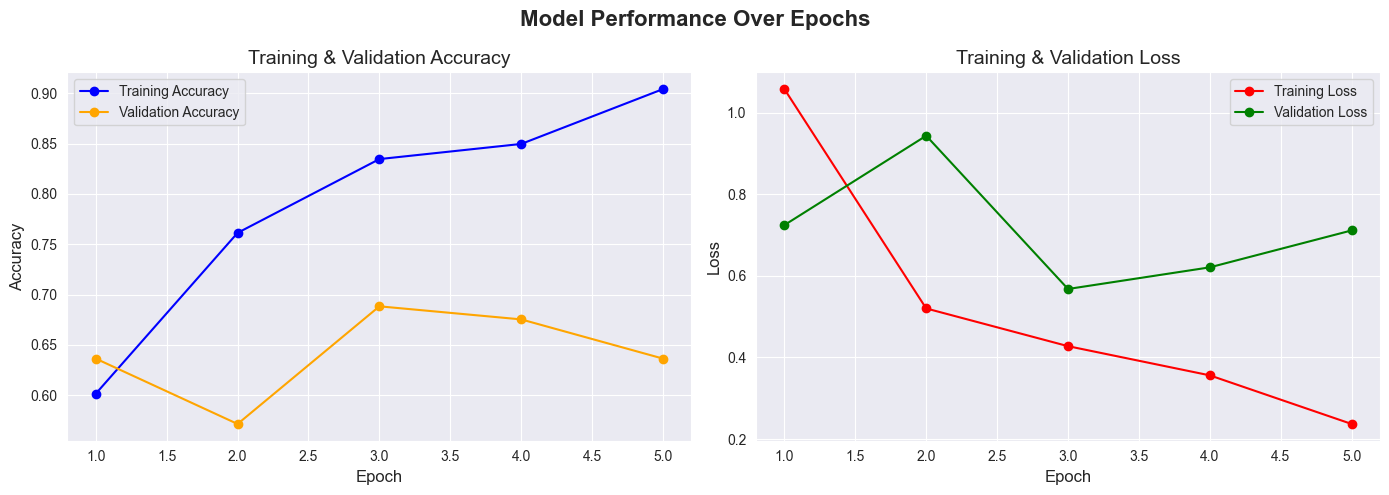

In [34]:
plot_training_history(history)

In [5]:

def plot_confusion_matrix_fancy(model=None, X=None, y=None, y_true=None, y_pred=None, normalize=False, direct_values=False):
    """
    Creates a fancy confusion matrix for a binary classification model
    with classes 0 (No Squint) and 1 (Squint).

    Args:
        model: Trained Keras model (model.predict() is used).
        X: Numpy array (or tf.Tensor) of input data (e.g. X_val, X_test).
        y: Ground-truth labels (integer-coded: 0 or 1).
        y_true: Direct ground truth values (used if direct_values=True)
        y_pred: Direct predicted values (used if direct_values=True)
        normalize (bool): If True, displays proportions. Otherwise, raw counts.
        direct_values (bool): If True, use y_true and y_pred directly instead of model predictions
    """
    if not direct_values:
        # 1) Predict with your model
        y_probs = model.predict(X)

        # If y is one-hot encoded, convert to integer-coded
        if len(y.shape) > 1 and y.shape[1] > 1:
            y_true = np.argmax(y, axis=1)
        else:
            y_true = y

        # Predicted classes
        y_pred = np.argmax(y_probs, axis=1)

    # 2) Create confusion matrix forcing order [0,1]
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])

    # Rest of the function remains exactly the same
    if normalize:
        cm = cm.astype("float") / cm.sum(axis=1, keepdims=True)

    sns.set(style="whitegrid", font_scale=1.2)
    fig, ax = plt.subplots(figsize=(6, 5))

    class_names = ["No Squint (0)", "Squint (1)"]

    sns.heatmap(
        cm,
        annot=True,
        fmt=".2f" if normalize else "d",
        cmap="YlOrBr",
        xticklabels=class_names,
        yticklabels=class_names,
        cbar=True,
        square=True,
        ax=ax
    )

    title_suffix = " (Normalized)" if normalize else ""
    ax.set_title(f"Confusion Matrix{title_suffix}", fontsize=16, pad=12)
    ax.set_xlabel("Predicted Label", fontsize=12)
    ax.set_ylabel("True Label", fontsize=12)
    plt.tight_layout()
    plt.show()

2/2 [==============================] - 0s 16ms/step


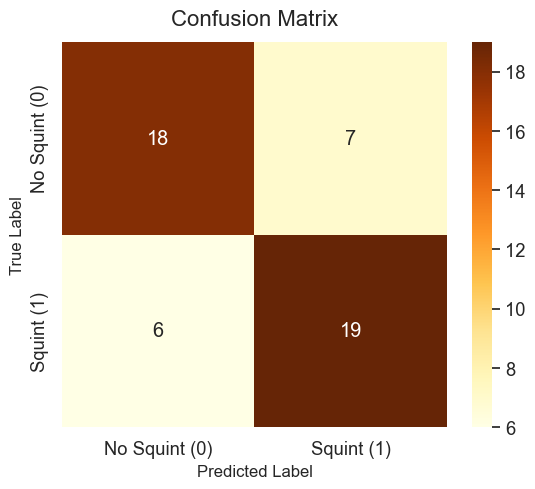

In [25]:
# If your validation labels are integer-coded (0 or 1)
plot_confusion_matrix_fancy(model, X_val, y_val, normalize=False)

4/4 [==============================] - 0s 20ms/step


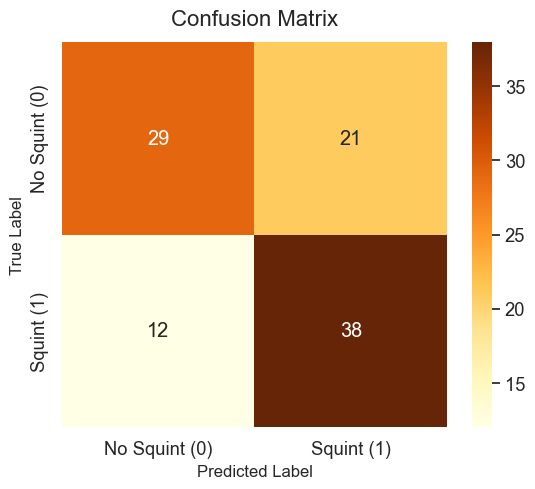

In [26]:
# Predict on test data
# (If it's a binary or multi-class classification with softmax)
y_probs_test = model.predict(X_test)
y_pred_test = np.argmax(y_probs_test, axis=1)  # pick the highest-probability class

# Plot a fancy confusion matrix with test data
plot_confusion_matrix_fancy(model, X_test, y_test, normalize=False)


In [17]:
class SquintDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = Path(root_dir)
        self.transform = transform
        self.images = []
        self.labels = []
        
        # Non-squinting (label 0)
        non_squint_path = self.root_dir / 'non_squinting'
        for img_path in non_squint_path.glob('*'):
            if img_path.suffix.lower() in ['.jpg', '.jpeg', '.png']:
                self.images.append(img_path)
                self.labels.append(0)
        
        # Squinting (label 1)
        squint_path = self.root_dir / 'squinting'
        for img_path in squint_path.glob('*'):
            if img_path.suffix.lower() in ['.jpg', '.jpeg', '.png']:
                self.images.append(img_path)
                self.labels.append(1)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        image = Image.open(img_path)
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.float)

def get_dataloaders(train_transforms, inference_transforms, data_dir='rescaled_data', batch_size=32, num_workers=4):

    # Create full dataset
    full_dataset = SquintDataset(data_dir, transform=train_transforms)
    
    # Calculate splits
    total_size = len(full_dataset)
    train_size = int(0.7 * total_size)
    val_size = int(0.1 * total_size)
    test_size = total_size - train_size - val_size

    train_dataset, val_dataset, test_dataset = random_split(
        full_dataset, 
        [train_size, val_size, test_size],
        generator=torch.Generator().manual_seed(42)
    )

    val_dataset.dataset.transform = inference_transforms
    test_dataset.dataset.transform = inference_transforms

    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True
    )

    return train_loader, val_loader, test_loader

In [18]:
class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size(0), -1)

class Mul(nn.Module):
    def __init__(self, scale):
        super().__init__()
        self.scale = scale
    def forward(self, x):
        return x * self.scale

def conv(ch_in, ch_out):
    return nn.Conv2d(ch_in, ch_out, kernel_size=3, 
                     padding='same', bias=False)

class ChannelAttention(nn.Module):
    def __init__(self, channels, reduction=16):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channels, channels // reduction, bias=False),
            nn.GELU(),
            nn.Linear(channels // reduction, channels, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

class SpatialAttention(nn.Module):
    def __init__(self, dim, num_heads=4):
        super().__init__()
        self.num_heads = num_heads
        self.attention = nn.MultiheadAttention(dim, num_heads, batch_first=True)
        # Optional projection layers
        self.q_proj = nn.Linear(dim, dim)
        self.k_proj = nn.Linear(dim, dim)
        self.v_proj = nn.Linear(dim, dim)

    def forward(self, x):
        # Reshape to (batch, seq_len=1, channels)
        x = x.unsqueeze(1)
        # Project queries, keys, and values
        q = self.q_proj(x)
        k = self.k_proj(x)
        v = self.v_proj(x)
        # Apply attention
        out, _ = self.attention(q, k, v)
        return out.squeeze(1)

def make_net(output_dim=1):
    act = lambda: nn.GELU()
    bn = lambda ch: nn.BatchNorm2d(ch)
    return nn.Sequential(
        nn.Sequential(
            nn.Conv2d(1, 24, kernel_size=2, padding=0, bias=True),
            act(),
            nn.Dropout2d(0.1),  # Light dropout in early layers
        ),
        nn.Sequential(
            conv(24, 64),
            nn.MaxPool2d(2),
            bn(64), act(),
            nn.Dropout2d(0.2),
            conv(64, 64),
            bn(64), act(),
            nn.Dropout2d(0.2),
        ),
        nn.Sequential(
            conv(64, 256),
            nn.MaxPool2d(2),
            bn(256), act(),
            nn.Dropout2d(0.3),
            conv(256, 256),
            bn(256), act(),
            nn.Dropout2d(0.3),
            ChannelAttention(256),
        ),
        nn.Sequential(
            conv(256, 256),
            nn.MaxPool2d(2),
            bn(256), act(),
            nn.Dropout2d(0.4),
            conv(256, 256),
            bn(256), act(),
            nn.Dropout2d(0.4),
        ),
        nn.AdaptiveAvgPool2d((1, 1)),
        Flatten(),
        nn.Dropout(0.5),  # Regular dropout before final linear layer
        nn.Linear(256, output_dim, bias=False),
        Mul(1/9)
    )

class plmodel(pl.LightningModule):
    def __init__(self, model, num_classes, lr, num_epochs):
        super().__init__()
        self.save_hyperparameters()
        self.model = model
        self.train_acc = Accuracy(task='binary')
        self.val_acc = Accuracy(task='binary')
        self.test_acc = Accuracy(task='binary')
    
    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self.model(x)
        
        logits = logits.squeeze(1)
        y = y.float()
        
        loss = F.binary_cross_entropy_with_logits(logits, y)
        
        pred_class = (torch.sigmoid(logits) > 0.5).float()
        self.train_acc.update(pred_class, y)
        
        self.log('train_loss', loss, prog_bar=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self.model(x)
        
        logits = logits.squeeze(1)
        y = y.float()
        
        loss = F.binary_cross_entropy_with_logits(logits, y)
    
        pred_class = (torch.sigmoid(logits) > 0.5).float()
        self.val_acc.update(pred_class, y)
        
        self.log('val_loss', loss, prog_bar=True)
    
    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self.model(x)
        
        logits = logits.squeeze(1)
        y = y.float()
        
        loss = F.binary_cross_entropy_with_logits(logits, y)
        
        pred_class = (torch.sigmoid(logits) > 0.5).float()
        self.test_acc.update(pred_class, y)
        
        self.log('test_loss', loss, prog_bar=True)

    def on_train_epoch_end(self):
        self.log('train_acc', self.train_acc.compute(), prog_bar=True, on_epoch=True, on_step=False)

    def on_validation_epoch_end(self):
        self.log('val_acc', self.val_acc.compute(), prog_bar=True, on_epoch=True, on_step=False)

    def on_test_epoch_end(self):
        self.log('test_acc', self.test_acc.compute(), prog_bar=True, on_epoch=True, on_step=False)
    
    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.hparams.lr, betas=(0.90, 0.95), weight_decay=0.01)
        
        # Create warmup scheduler
        warmup_steps = int(0.1 * self.hparams.num_epochs)  # 10% of total epochs for warmup
        warmup_scheduler = torch.optim.lr_scheduler.LinearLR(
            optimizer,
            start_factor=0.01,  # Start at 1% of max lr
            end_factor=1.0,
            total_iters=warmup_steps
        )
        
        # Create decay scheduler
        decay_scheduler = torch.optim.lr_scheduler.LinearLR(
            optimizer,
            start_factor=1.0,
            end_factor=0.01,
            total_iters=self.hparams.num_epochs - warmup_steps
        )
        
        # Combine schedulers
        scheduler = torch.optim.lr_scheduler.SequentialLR(
            optimizer,
            schedulers=[warmup_scheduler, decay_scheduler],
            milestones=[warmup_steps]
        )
        
        return {"optimizer": optimizer, "lr_scheduler": {"scheduler": scheduler, "interval": "epoch"}}

In [ ]:
def train(
    train_transforms: None,
    inference_transforms : None,
    name: str,
    model=None,
    num_epochs: int=10,
    seed: int=random.randint(0, 2**32 - 1),
    num_workers: int=0,
    batch_size: int=32,   
    lr: float=2e-4,
):
    # Set random seeds for reproducibility
    pl.seed_everything(seed)
    
    # Get dataloaders
    trainloader, valloader, testloader = get_dataloaders(
        batch_size=batch_size,
        num_workers=num_workers,
        train_transforms=train_transforms,
        inference_transforms=inference_transforms
    )
    
    if model is None:
        model = make_net(output_dim=1)  # Binary classification
    
    #model = torch.compile(model)
    model = plmodel(
        model=model, 
        num_classes=1,  # Binary classification
        lr=lr, 
        num_epochs=num_epochs
    )

    logger = TensorBoardLogger(
        save_dir="tensorboard_logs",
        name=name,
        default_hp_metric=False 
    )
    
    checkpoint_callback = ModelCheckpoint(
        monitor='val_acc',
        dirpath='checkpoints',
        filename=f'{name}-{{epoch:02d}}-{{val_acc:.2f}}',
        save_top_k=3,
        mode='max',
    )

    final_checkpoint = ModelCheckpoint(
        dirpath='checkpoints',
        filename=f'{name}-final',
        save_on_train_epoch_end=True
    )

    trainer = pl.Trainer(
        max_epochs=num_epochs,
        accelerator='cuda', 
        devices=1,
        log_every_n_steps=10,
        logger=logger,
        callbacks=[final_checkpoint, checkpoint_callback],
        enable_progress_bar=True,
    )

    # Train and test
    trainer.fit(model, trainloader, valloader)
    trainer.test(model, testloader)
    
    return model

base_config = {
    'batch_size': 32,
    'num_epochs': 1500,
    'name': 'squint_detector',
    'lr' : 0.00165,
    'train_transforms' : transforms.Compose([
        transforms.ToTensor(),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.GaussianBlur(kernel_size=(5, 5), sigma=(0.1, 2.0)),
        transforms.Normalize(mean=[0.395], std=[0.189])
    ]),
    'inference_transforms' : transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.395], std=[0.189])
    ])
}

model = make_net(output_dim=1)  # Binary classification
trained_model = train(
    model=model,
    lr=base_config['lr'],
    num_epochs=base_config['num_epochs'],
    name=base_config['name'],
    batch_size=base_config['batch_size'],
    train_transforms=base_config['train_transforms'],
    inference_transforms=base_config['inference_transforms']
)

Seed set to 42


Training Set Confusion Matrix:


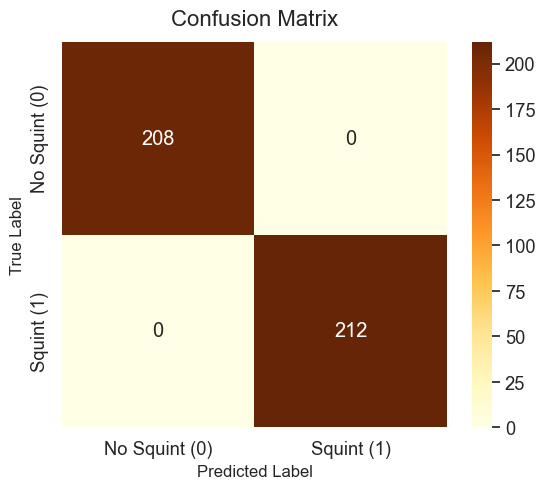


Validation Set Confusion Matrix:


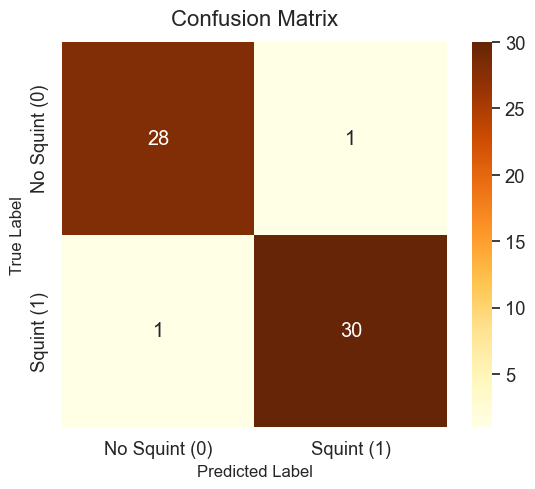


Test Set Confusion Matrix:


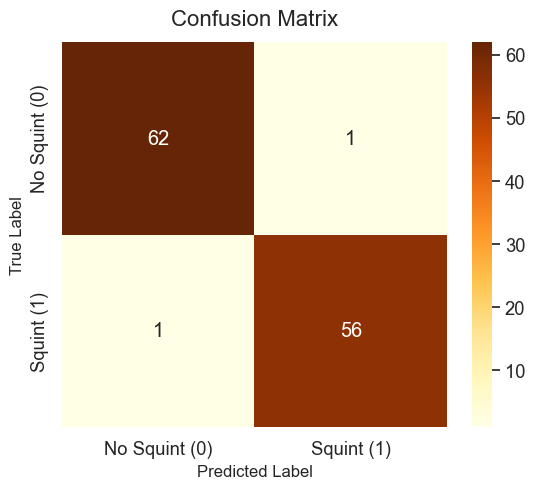

In [16]:
checkpoint_path = 'checkpoints/squint_detector-epoch=1499-val_acc=0.94.ckpt'
batch_size = 32
seed = 42

# Set seed for reproducibility
pl.seed_everything(seed)

# Get all dataloaders
trainloader, valloader, testloader = get_dataloaders(
    batch_size=batch_size,
    num_workers=0
)

# Load model
base_model = make_net()
model = plmodel.load_from_checkpoint(
    checkpoint_path,
    model=base_model,
    num_classes=1,
    lr=0.00165,
    num_epochs=50,
    strict=False
)
model.eval()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Function to get predictions for a dataloader
def get_predictions(model, dataloader, device):
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for batch in dataloader:
            inputs, labels = batch
            inputs = inputs.to(device)
            outputs = model(inputs)
            preds = (torch.sigmoid(outputs.squeeze()) > 0.5).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())
    return np.array(all_labels), np.array(all_preds)

# Get predictions for all splits
print("Training Set Confusion Matrix:")
y_true_train, y_pred_train = get_predictions(model, trainloader, device)
plot_confusion_matrix_fancy(y_true=y_true_train, y_pred=y_pred_train, direct_values=True, normalize=False)

print("\nValidation Set Confusion Matrix:")
y_true_val, y_pred_val = get_predictions(model, valloader, device)
plot_confusion_matrix_fancy(y_true=y_true_val, y_pred=y_pred_val, direct_values=True, normalize=False)

print("\nTest Set Confusion Matrix:")
y_true_test, y_pred_test = get_predictions(model, testloader, device)
plot_confusion_matrix_fancy(y_true=y_true_test, y_pred=y_pred_test, direct_values=True, normalize=False)